In [1]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import scipy.stats as st
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr        

from IPython.display import display
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator

In [3]:
from plotnine import ggplot, geom_boxplot, aes, stat_smooth, facet_wrap, theme_matplotlib, ylim
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['svg.fonttype'] = 'none'
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.grid.which'] = 'both'
rcParams['grid.color'] = "black"
rcParams['grid.linestyle'] = 'dashed'
rcParams['lines.linewidth'] = 1
rcParams['axes.linewidth'] = 0.5
rcParams['grid.linewidth'] = 0.25
rcParams['grid.alpha'] = 0.5
rcParams['figure.subplot.wspace'] = 0.4
rcParams['figure.subplot.hspace'] = 0.5
rcParams['axes.labelpad'] = 0.5

rcParams['axes.labelsize'] = 11
rcParams['axes.labelweight'] = "normal"
rcParams['axes.titlesize'] = 12
rcParams['axes.titleweight'] = "bold"
rcParams['figure.titlesize'] = 14
rcParams['figure.titleweight'] = "bold"
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 11
rcParams['legend.title_fontsize'] = 12
rcParams['legend.title_fontsize'] = 12

In [4]:
rnaseq = pd.read_csv("data/Fig3/both_rnaseq_2020_05.tsv", sep="\t")

In [5]:
diff_rnaseq = pd.read_csv("data/Fig3/differentiation_rnaseq.tsv", sep="\t")
at_mean = rnaseq[rnaseq["comparison_person"]=="ZFC4mut vs WT RP"][["gene_id","AT mean"]].set_index("gene_id")["AT mean"].to_dict()
diff_rnaseq.loc[diff_rnaseq.index, "AT mean"] = diff_rnaseq.copy()["gene_id"].apply(lambda x: at_mean.get(x, np.nan))

In [6]:
def gene_body_plot(matrix_file, ax, groups=5, cmap="Reds"):
    
    palette = sns.color_palette(cmap, groups+2).as_hex()[2:]
    
    matrix_df = pd.read_csv(matrix_file, sep="\t", comment="@", header=None)
    matrix_df.loc[list(matrix_df.index), "AT mean"] = list(matrix_df[matrix_df.columns[5:]].mean(axis=1).values)
    matrix_df.loc[list(matrix_df.index), "group"] = list(pd.qcut(matrix_df["AT mean"], groups, labels=list(range(1, groups+1))).values)
    matrix_df = matrix_df.drop("AT mean", axis=1)
    
    for (i, j), c in zip(matrix_df.groupby("group"), palette):
        jj = j[list(range(6,1706))]
        jmean = jj.mean().values
        ax.plot(range(len(jj.columns)), jmean, linewidth=0.5, color=c)    
        down, up = sms.DescrStatsW(jj).tconfint_mean(alpha=0.001, alternative="two-sided")    
        ax.fill_between(list(range(len(jj.columns))), up, down, color=c, linewidth=0, alpha=0.25)
    
    ax.set_ylim(0.35, 0.65)
    ax.set_yticks([0.4, 0.5, 0.6])
    ax.set_xlim(0,1700)
    ax.set_xticks([0, 500, 1500, 1700])
    ax.set_xticklabels(["-5k", "TSS", "TES", "+2k"], rotation=90)        
    ax.set_ylabel("AT")

def fold_change_plot(rnaseq_df, genes, ax, comparisons=["KO vs WT TQ", "ZFC4mut vs WT TQ", "ZFC4D vs WT TQ"], 
                     labels=["KO vs WT", "ZFC4mut\nvs WT", "ZFC4Δ\nvs WT"], groups=5, cmap="Reds", ymin=-2.5, ymax=2.5, yticks=[-2, 0, 2]):
    
    palette = sns.color_palette(cmap, groups+2).as_hex()[2:]
    temp = rnaseq_df[(rnaseq_df["gene_id"].isin(genes)) & (rnaseq_df["comparison_person"].isin(comparisons))].copy()
    temp.loc[list(temp.index), "group"] = list(pd.qcut(temp["AT mean"], groups, labels=list(range(1, groups+1))).values)
    sns.pointplot(data=temp, x="comparison_person", y="log2FoldChange", hue="group", join=False, dodge=0.475, 
                  hue_order=[1,2,3,4,5], legend=False, ax=ax, ci="sd", scale=0.7, errwidth=0.5, capsize=0.05, 
                  palette=palette, order=comparisons)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend().set_visible(False)
    ax.set_xlabel("")    
    ax.set_ylabel(r"$\mathregular{log_2}$ fold change")    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(yticks)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.axhline(y=0, linestyle="solid", color="black", linewidth=0.5, zorder=-2)
    
def diff_fold_change_plot(rnaseq_df, genes, ax, comparisons=["KO vs WT TQ", "ZFC4mut vs WT TQ", "ZFC4D vs WT TQ"], 
                     labels=["KO vs WT", "ZFC4mut\nvs WT", "ZFC4Δ\nvs WT"], groups=5, cmap="Reds", ymin=-2.5, ymax=2.5, yticks=[-2, 0, 2]):
    
    palette = sns.color_palette(cmap, groups+2).as_hex()[2:]
    temp = rnaseq_df[(rnaseq_df["gene_id"].isin(genes)) & (rnaseq_df["cell_line"].isin(comparisons))].copy()
    temp.loc[list(temp.index), "group"] = list(pd.qcut(temp["AT mean"], groups, labels=list(range(1, groups+1))).values)
    sns.pointplot(data=temp, x="cell_line", y="log2FoldChange vs 0", hue="group", join=False, dodge=0.475, 
                  hue_order=[1,2,3,4,5], legend=False, ax=ax, ci="sd", scale=0.7, errwidth=0.5, capsize=0.05, 
                  palette=palette, order=comparisons)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend().set_visible(False)
    ax.set_xlabel("")    
    ax.set_ylabel(r"$\mathregular{log_2}$ fold change")    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(yticks)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.axhline(y=0, linestyle="solid", color="black", linewidth=0.5, zorder=-2)

def stats_plot(stats_file, ax, genes="TQ ZFC4", comparisons=["KO vs WT TQ", "ZFC4mut vs WT TQ", "ZFC4D vs WT TQ"], 
               labels=["KO vs WT", "ZFC4mut\nvs WT", "ZFC4Δ\nvs WT"], color="#e41a1c"):
    stats_df = pd.read_csv(stats_file, sep="\t")
    stats_df["min_error"] = stats_df["mean_effect"] - stats_df["min_effect"]
    stats_df["max_error"] = stats_df["max_effect"] - stats_df["mean_effect"]
    stats_df = stats_df[(stats_df["genes"]==genes) & (stats_df["sample"].isin(comparisons))].copy()
    stats_df.index = stats_df["sample"]
    stats_df = stats_df.reindex(comparisons).copy()
    for ii, jj, kk, ll, mm in zip(stats_df["mean_effect"].values, range(0, len(comparisons)), 
                                  stats_df[["min_error","max_error"]].values, 
                                  2.5*stats_df["pointsize"].values, stats_df["minus_log10_padjust_fvalue"].values):        
        if mm < 2:
            ax.errorbar(jj, ii, yerr=np.array([kk]).T, markersize=5, markeredgecolor=color, color="white", fmt="o", linewidth=0.5,
                   elinewidth=1, ecolor=color, capsize=0.1)
        else:
            ax.errorbar(jj, ii, yerr=np.array([kk]).T, markersize=5, markeredgecolor="black", color=color, fmt="o", linewidth=0.5,
                   elinewidth=1, capsize=0.1)
    ax.set_xlim(-0.5, len(comparisons)-0.5)
    ax.set_xticks(range(len(comparisons)))
    ax.set_xticklabels(labels, rotation=90)    
    ax.set_ylim(-2, 12)
    ax.set_yticks([0, 5, 10])
    ax.axhline(y=0, linestyle="solid", color="black", linewidth=0.5, zorder=-2)
    ax.set_ylabel("AT effect size")

# Figure 3A, 3F, 3J

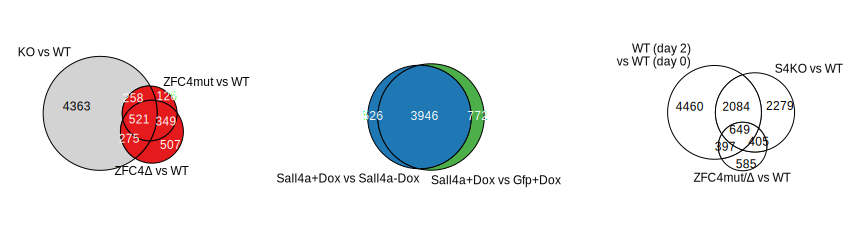

In [7]:
tq = rnaseq[(rnaseq["experiment"]=="TQ") & (rnaseq["padj"]<0.05)]
tq_mut_genes = set(tq[(tq["padj"]<0.05) & (tq["comparison"]=="ZFC4mut vs WT")]["gene_id"].values)
tq_del_genes = set(tq[(tq["padj"]<0.05) & (tq["comparison"]=="ZFC4D vs WT")]["gene_id"].values)
tq_ko_genes = set(tq[(tq["padj"]<0.05) & (tq["comparison"]=="KO vs WT")]["gene_id"].values)
rp = rnaseq[(rnaseq["experiment"]=="RP") & (rnaseq["padj"]<0.05)]
rp_zfc12d_genes = set(rp[(rp["padj"]<0.05) & (rp["comparison"]=="ZFC1-2D vs WT")]["gene_id"].values)
rp_zfc4mut_genes = set(rp[(rp["padj"]<0.05) & (rp["comparison"]=="ZFC4mut vs WT")]["gene_id"].values)
deseq20 = pd.read_csv("data/Fig3/timepoint_2_vs_0.tsv", sep="\t", index_col=0)
day20_genes = set(deseq20[deseq20["padj"]<0.05].index)
rp_zfc4_exclusive_genes = set(pd.read_csv("data/Fig3/rp_zfc4_exclusive_regulated_genes.bed", sep="\t", header=None)[3].values)
sall4_dox_genes = set(rp[rp["comparison"]=="Sall4a+Dox vs Sall4a-Dox"]["gene_id"].values)
sall4_vs_gfp_dox_genes = set(rp[rp["comparison"]=="Sall4a+Dox vs GFP+Dox"]["gene_id"].values)

from matplotlib_venn import venn2, venn3
fig, (ax, bx, dx) = plt.subplots(1, 3, figsize=(15,5))

def set_venn_scale(ax, true_area, reference_area):
    s = np.sqrt(float(reference_area)/true_area)
    ax.set_xlim(-s, s)
    ax.set_ylim(-s, s)
    
c = venn3((tq_ko_genes, tq_mut_genes, tq_del_genes), set_labels=("KO vs WT", "ZFC4mut vs WT", "ZFC4Δ vs WT"), set_colors=("lightgray", "#e41a1c", "#e41a1c"),
     alpha=1, ax=ax)
for cc in c.patches:
    cc.set_linewidth(1)
    cc.set_linestyle("solid")
    cc.set_edgecolor("black")
    cc.set_alpha(1)
for cc in c.subset_labels:
    cc.set_fontsize(12)
    cc.set_color("white")
c.get_label_by_id("100").set_color("black")
for l in ["111", "110", "011", "101"]:
    c.get_patch_by_id(l).set_color("#e41a1c")
    c.get_patch_by_id(l).set_alpha(1)
    c.get_patch_by_id(l).set_linewidth(1)
    c.get_patch_by_id(l).set_linestyle("solid")
    c.get_patch_by_id(l).set_edgecolor("black")
for cc in c.set_labels:
    cc.set_fontsize(12)
num_1 = []
for cc in c.subset_labels:
    num_1.append(int(cc.get_text()))

c = venn2((sall4_dox_genes, sall4_vs_gfp_dox_genes), set_labels=("Sall4a+Dox vs Sall4a-Dox", "Sall4a+Dox vs Gfp+Dox"), 
          set_colors=("#1f78b4", "#4daf4a"), alpha=1, ax=bx)
c.get_patch_by_id("11").set_color("#1f78b4")
for cc in c.patches:
    cc.set_linewidth(1)
    cc.set_linestyle("solid")
    cc.set_edgecolor("black")
    cc.set_alpha(1)
for cc in c.subset_labels:
    cc.set_fontsize(12)
    cc.set_color("white")
c.get_label_by_id("11").set_color("white")
for cc in c.set_labels:
    cc.set_fontsize(12)
num_2 = []
for cc in c.subset_labels:
    num_2.append(int(cc.get_text()))
    
v = venn3((day20_genes, tq_ko_genes, tq_mut_genes.union(tq_del_genes)), 
          set_colors=("white", "white", "white"), alpha=1, set_labels=("WT (day 2)\nvs WT (day 0)", "S4KO vs WT", "ZFC4mut/Δ vs WT" ), ax=dx)
for cc in v.patches:
    cc.set_linewidth(1)
    cc.set_linestyle("solid")
    cc.set_edgecolor("black")
for text in v.set_labels:
    text.set_fontsize(12)
for text in v.subset_labels:
    text.set_fontsize(12)
num_4 = []
for cc in c.subset_labels:
    num_4.append(int(cc.get_text()))
    
max_area = max_area = max(map(sum, [num_1, num_2, num_4]))
for a, d in zip([ax, bx, dx], [num_1, num_2, num_4]):
    set_venn_scale(a, sum(d), max_area)

# Figure 3B, 3C

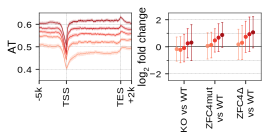

In [8]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(4,1.25), gridspec_kw={'width_ratios': (3,3)})
tq_zfc4_genes = list(pd.read_csv("data/Fig3/tq_zfc4_regulated_genes.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/tq_zfc4_regulated_genes.AT.matrix.gz", ax, cmap="Reds")
fold_change_plot(rnaseq, tq_zfc4_genes, bx, cmap="Reds")

# Figure S3B, 3D

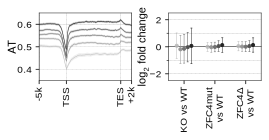

In [9]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(4,1.25), gridspec_kw={'width_ratios': (3,3)})
tq_ko_genes = list(pd.read_csv("data/Fig3/tq_ko_exclusive_regulated_genes.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/tq_ko_exclusive_regulated_genes_AT.matrix.gz", ax, cmap="Greys")
fold_change_plot(rnaseq, tq_ko_genes, bx, cmap="Greys")

# Figure S2G, 2G

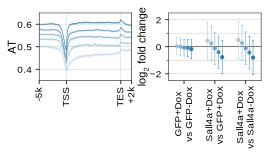

In [10]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(4,1.25), gridspec_kw={'width_ratios': (3,3)})
recovery_genes = list(pd.read_csv("data/Fig3/dox_dark_blue.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/dox_dark_blue_genes.AT.matrix.gz", ax, cmap=sns.light_palette("#1f78b4", 7))
fold_change_plot(rnaseq, recovery_genes, bx, cmap=sns.light_palette("#1f78b4", 7), comparisons=["GFP+Dox vs GFP-Dox RP", "Sall4a+Dox vs GFP+Dox RP", "Sall4a+Dox vs Sall4a-Dox RP"],
              labels=["GFP+Dox\nvs GFP-Dox", "Sall4a+Dox\nvs GFP+Dox", "Sall4a+Dox\nvs Sall4a-Dox"])

# Figure 3B, 3H

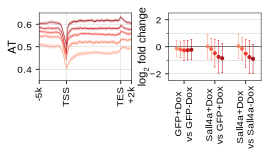

In [11]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(4,1.25), gridspec_kw={'width_ratios': (3,3)})
tq_zfc4_genes = list(pd.read_csv("data/Fig3/tq_zfc4_regulated_genes.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/tq_zfc4_regulated_genes.AT.matrix.gz", ax, cmap="Reds")
fold_change_plot(rnaseq, tq_zfc4_genes, bx, cmap="Reds", comparisons=["GFP+Dox vs GFP-Dox RP", "Sall4a+Dox vs GFP+Dox RP", "Sall4a+Dox vs Sall4a-Dox RP"],
              labels=["GFP+Dox\nvs GFP-Dox", "Sall4a+Dox\nvs GFP+Dox", "Sall4a+Dox\nvs Sall4a-Dox"])

# Figure S3F

<ipython-input-12-ba8a2d0e80ed>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  cx.scatter(temp["KO vs WT"], temp["Sall4a+Dox vs Sall4a-Dox"], c=z, s=5, cmap="plasma", edgecolor="")


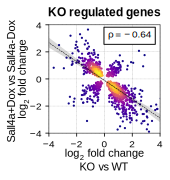

In [12]:
fig, cx = plt.subplots(figsize=(2,2))
temp = rnaseq[(rnaseq["gene_id"].isin(set(tq_ko_genes).intersection(sall4_dox_genes))) & (rnaseq["comparison_person"].isin(["KO vs WT TQ", 
                               "Sall4a+Dox vs Sall4a-Dox RP"]))].pivot(index="gene_id", values="log2FoldChange", columns="comparison").dropna()
xy = np.vstack([temp["KO vs WT"], temp["Sall4a+Dox vs Sall4a-Dox"]])
z = gaussian_kde(xy)(xy)  
cx.scatter(temp["KO vs WT"], temp["Sall4a+Dox vs Sall4a-Dox"], c=z, s=5, cmap="plasma", edgecolor="")
sns.regplot(data=temp, x="KO vs WT", y="Sall4a+Dox vs Sall4a-Dox", scatter=False, color="black", 
            line_kws={'linewidth': 0.5, 'linestyle': 'dashed'}, ax=cx)
cx.set_xlim(-4, 4)
cx.set_ylim(-4, 4)
cx.set_xticks([-4, -2, 0, 2, 4])
cx.set_yticks([-4, -2, 0, 2, 4])
corr_value = temp.corr().values[0][-1]
cx.text(0.25, 3, r"$\mathregular{\rho=" +"{:.2f}".format(corr_value) + "}$", fontsize="10", bbox=dict(facecolor='white', edgecolor='black'))
# cx.set_title("KO regulated genes\n(Strict, n={:,})".format(len(temp)), y=1.025)
cx.set_title("KO regulated genes", y=1.025)
cx.set_xlabel(r"$\mathregular{log_2}$ fold change" + "\nKO vs WT", fontweight="normal")
_ = cx.set_ylabel("Sall4a+Dox vs Sall4a-Dox\n" + r"$\mathregular{log_2}$ fold change", fontweight="normal")

# Figure S3J, S3K

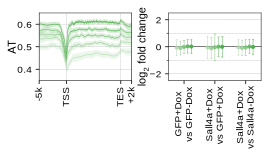

In [13]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(4,1.25), gridspec_kw={'width_ratios': (3,3)})
dox_genes = list(pd.read_csv("data/Fig3/dox_light_blue.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/dox_light_blue_genes.AT.matrix.gz", ax, cmap=sns.light_palette("#4daf4a", 7))
fold_change_plot(rnaseq, dox_genes, bx, cmap=sns.light_palette("#4daf4a", 7), comparisons=["GFP+Dox vs GFP-Dox RP", "Sall4a+Dox vs GFP+Dox RP", "Sall4a+Dox vs Sall4a-Dox RP"],
              labels=["GFP+Dox\nvs GFP-Dox", "Sall4a+Dox\nvs GFP+Dox", "Sall4a+Dox\nvs Sall4a-Dox"])

# Figure S3M, 3K

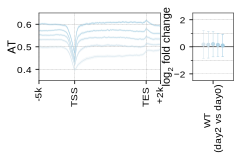

In [14]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(3.5,1.25), gridspec_kw={'width_ratios': (3,1)})
day20_genes = list(pd.read_csv("data/Fig3/day20_exclusive_tq.genes.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/day20_exclusive_tq.genes.AT.matrix.gz", ax, cmap=sns.light_palette("#a6cee3", 7))
diff_fold_change_plot(diff_rnaseq, day20_genes, bx, cmap=sns.light_palette("#a6cee3", 7), comparisons=["WT2.vs.WT\n2.vs.0"],
              labels=["WT\n(day2 vs day0)"])

# Figure S3B, 3K

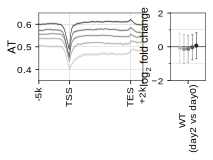

In [15]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(3,1.25), gridspec_kw={'width_ratios': (3,1)})
tq_ko_genes = list(pd.read_csv("data/Fig3/tq_ko_regulated_genes.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/tq_ko_regulated_genes.AT.matrix.gz", ax, cmap="Greys")
diff_fold_change_plot(diff_rnaseq, tq_ko_genes, bx, cmap="Greys", comparisons=["WT2.vs.WT\n2.vs.0"],
              labels=["WT\n(day2 vs day0)"], ymin=-2, ymax=2)

# Figure 3B, 3K

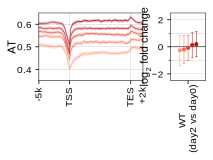

In [16]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(3,1.25), gridspec_kw={'width_ratios': (3,1)})
rp_zfc4_genes = list(pd.read_csv("data/Fig3/tq_zfc4_regulated_genes.bed", sep="\t", header=None)[3].values)
gene_body_plot("data/Fig3/tq_zfc4_regulated_genes.AT.matrix.gz", ax, cmap="Reds")
diff_fold_change_plot(diff_rnaseq, rp_zfc4_genes, bx, cmap="Reds", comparisons=["WT2.vs.WT\n2.vs.0"],
              labels=["WT\n(day2 vs day0)"])

In [17]:
stats_df = pd.read_csv("data/Fig3/combined_stats.tsv", sep="\t")
stats_df["min_error"] = stats_df["mean_effect"] - stats_df["min_effect"]
stats_df["max_error"] = stats_df["max_effect"] - stats_df["mean_effect"]
stats_df["pointsize"] = 2

# Figure S3A, S3C, S3H, S3I, S3L

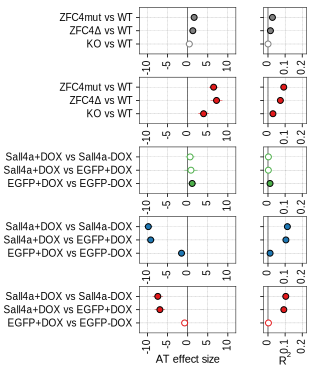

In [18]:
fig, (aax, bbx, ccx, ddx, eex) = plt.subplots(5, 2, figsize=(3, 6), sharey=False, sharex=False, gridspec_kw={'width_ratios': (9,4)})

for i, j, k, (bx, ax) in zip(reversed(["TQ KO", "TQ ZFC4", "NONDOX", "DOX", "TQ ZFC4"]), 
                   reversed([["ZFC4mut vs WT TQ", "ZFC4D vs WT TQ", "KO vs WT TQ"],
                    ["ZFC4mut vs WT TQ", "ZFC4D vs WT TQ", "KO vs WT TQ"],
                    ["Sall4a+Dox vs Sall4a-Dox RP", "Sall4a+Dox vs GFP+Dox RP", "GFP+Dox vs GFP-Dox RP"],
                    ["Sall4a+Dox vs Sall4a-Dox RP", "Sall4a+Dox vs GFP+Dox RP", "GFP+Dox vs GFP-Dox RP"],
                    ["Sall4a+Dox vs Sall4a-Dox RP", "Sall4a+Dox vs GFP+Dox RP", "GFP+Dox vs GFP-Dox RP"]]),
                   reversed(["grey", "#e41a1c", "#4daf4a", "#1f78b4", "#e41a1c"]), reversed([aax,bbx,ccx,ddx,eex])):
    yticklabels=[]
    start = 0
    current_df = stats_df[(stats_df["genes"]==i) & (stats_df["sample"].isin(j))].copy()    
    sort_dict = {}
    for ii, jj in zip(j, range(len(j),0,-1)):
        sort_dict[ii] = jj
    current_df.loc[current_df.index, "sort_order"] = list(current_df.copy()["sample"].apply(lambda x: sort_dict[x]).values)
    current_df = current_df.sort_values(by="sort_order")
    end = start+len(current_df)
    for ii, jj, ll, kk in zip(current_df["rsquared"].values, range(start, end), 7.5*current_df["pointsize"].values, current_df["minus_log10_padjust_fvalue"].values):
        if kk < 2:
            ax.errorbar(ii, jj, markersize=ll*0.4, color="white", fmt="o", ecolor=k, linewidth=0.5, markeredgecolor=k) 
        else:
            ax.errorbar(ii, jj, markersize=ll*0.4, color=k, fmt="o", linewidth=0.5, markeredgecolor="black") 
    for ii, jj, kk, ll, mm in zip(current_df["mean_effect"].values, range(start, end), current_df[["min_error", "max_error"]].values, 7.5*current_df["pointsize"].values, current_df["minus_log10_padjust_fvalue"].values):
        if mm < 2:
            bx.errorbar(ii, jj, xerr=np.array([kk]).T, markersize=ll*0.4, ecolor=k, markeredgecolor=k, color="white", fmt="o", linewidth=0.5,
                   elinewidth=0.5)
        else:
            bx.errorbar(ii, jj, xerr=np.array([kk]).T, markersize=ll*0.4, markeredgecolor="black", color=k, fmt="o", linewidth=0.5,
                   elinewidth=0.5)
    start=end+1
    if  "D20" in i:
        yticklabels += [iii.replace("S4B", "ZFC1-2Δ").replace("WT2", "WT").replace("Dox", "DOX").replace("GFP", "EGFP").replace(".vs.", "vs") for iii in current_df["sample"].values]
    else:
        yticklabels += [iii[:-3].replace("1-2D", "1-2Δ").replace("Dox", "DOX").replace("GFP", "EGFP").replace("ZFC4D", "ZFC4Δ") for iii in current_df["sample"].values]
    
    bx.set_yticks(range(len(yticklabels)))
    ax.set_yticks(range(len(yticklabels)))
    bx.set_yticklabels(yticklabels, fontsize="10")
    ax.set_xlim(-0.025, .225)
    bx.set_xlim(-12, 12)
    ax.set_xticks([0, 0.1, 0.2])    
    bx.set_xticks([-10, -5,  0, 5, 10])    
    ax.set_ylim(-0.75, end-0.25)
    bx.set_ylim(-0.75, end-0.25)
    ax.set_yticklabels([])
    bx.set_xticklabels([-10, -5,  0, 5, 10], rotation=90)
    ax.set_xticklabels([0,0.1,0.2], rotation=90)

    ax.axvline(x=0, linestyle="solid", color="black", linewidth=0.5)
    bx.axvline(x=0, linestyle="solid", color="black", linewidth=0.5)
    ax.grid(True, which="both", linestyle="dashed")
    bx.grid(True, which="both", linestyle="dashed")
eex[1].set_xlabel(r"$\mathregular{R^2}$")
_ = eex[0].set_xlabel("AT effect size")

# Figure S3N

Text(0.5, 0, 'AT effect size')

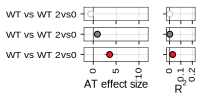

In [19]:
fig, (aax, bbx, ccx) = plt.subplots(3, 2, figsize=(2, 1), sharey=False, sharex=False, gridspec_kw={'width_ratios': (9,4)})

for i, j, k, (bx, ax) in zip(reversed(["FIG3K BLUE", "FIG3K GREY", "FIG3K RED"]), 
                   reversed([["WT2 vs WT 2.vs.0"],
                            ["WT2 vs WT 2.vs.0"],["WT2 vs WT 2.vs.0"]]),
                   reversed(["#a6cee3", "grey", "#e41a1c"]), reversed([aax, bbx, ccx])):
    yticklabels=[]
    start = 0
    current_df = stats_df[(stats_df["genes"]==i) & (stats_df["sample"].isin(j))].copy()    
    sort_dict = {}
    for ii, jj in zip(j, range(len(j),0,-1)):
        sort_dict[ii] = jj
    current_df.loc[current_df.index, "sort_order"] = list(current_df.copy()["sample"].apply(lambda x: sort_dict[x]).values)
    current_df = current_df.sort_values(by="sort_order")
    end = start+len(current_df)
    for ii, jj, ll, kk in zip(current_df["rsquared"].values, range(start, end), 7.5*current_df["pointsize"].values, current_df["minus_log10_padjust_fvalue"].values):
        if kk < 2:
            ax.errorbar(ii, jj, markersize=ll*0.4, color="white", fmt="o", ecolor=k, linewidth=0.5, markeredgecolor=k) 
        else:
            ax.errorbar(ii, jj, markersize=ll*0.4, color=k, fmt="o", linewidth=0.5, markeredgecolor="black") 
    for ii, jj, kk, ll, mm in zip(current_df["mean_effect"].values, range(start, end), current_df[["min_error", "max_error"]].values, 7.5*current_df["pointsize"].values, current_df["minus_log10_padjust_fvalue"].values):
        if mm < 2:
            bx.errorbar(ii, jj, xerr=np.array([kk]).T, markersize=ll*0.4, ecolor=k, markeredgecolor=k, color="white", fmt="o", linewidth=0.5,
                   elinewidth=0.5)
        else:
            bx.errorbar(ii, jj, xerr=np.array([kk]).T, markersize=ll*0.4, markeredgecolor="black", color=k, fmt="o", linewidth=0.5,
                   elinewidth=0.5)
    start=end+1
    if  "FIG3K" in i:
        yticklabels += [iii.replace("S4B", "ZFC1-2Δ").replace("WT2", "WT").replace("Dox", "DOX").replace("GFP", "EGFP").replace(".vs.", "vs") for iii in current_df["sample"].values]
    else:
        yticklabels += [iii[:-3].replace("1-2D", "1-2Δ").replace("Dox", "DOX").replace("GFP", "EGFP").replace("ZFC4D", "ZFC4Δ") for iii in current_df["sample"].values]
    
    bx.set_yticks(range(len(yticklabels)))
    ax.set_yticks(range(len(yticklabels)))
    bx.set_yticklabels(yticklabels, fontsize="10")
    ax.set_xlim(-0.025, .225)
    bx.set_xlim(-2, 12)
    ax.set_xticks([0, 0.1, 0.2])    
    bx.set_xticks([0, 5, 10])    
    ax.set_ylim(-0.75, end-0.25)
    bx.set_ylim(-0.75, end-0.25)    
    bx.set_xticklabels([0, 5, 10], rotation=90)
    ax.set_xticklabels([0,0.1,0.2], rotation=90)
    ax.set_yticklabels([])
    ax.axvline(x=0, linestyle="solid", color="black", linewidth=0.5)
    bx.axvline(x=0, linestyle="solid", color="black", linewidth=0.5)
    ax.grid(True, which="both", linestyle="dashed")
    bx.grid(True, which="both", linestyle="dashed")
ccx[1].set_xlabel(r"$\mathregular{R^2}$")
ccx[0].set_xlabel("AT effect size")

In [20]:
from sinfo import sinfo
sinfo()

-----
matplotlib          3.3.2
matplotlib_venn     NA
numpy               1.19.2
pandas              1.1.3
plotnine            0.6.0
scipy               1.5.2
seaborn             0.11.0
sinfo               0.3.1
sklearn             0.23.2
statsmodels         0.12.0
-----
IPython             7.18.1
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.2.8
notebook            6.1.4
-----
Python 3.8.6 (default, Sep 30 2020, 04:00:38) [GCC 10.2.0]
Linux-5.4.71-1-lts-x86_64-with-glibc2.2.5
4 logical CPU cores
-----
Session information updated at 2020-10-18 21:49
